
# Kuramoto project code


### ATTENTION!!!!
1) If you wonna run this code on your local GPU device, make sure that you set TDR limit to FALSE mode!!!
<br>
2) Overwise, you will always caught CUDA_TIMEOUT_ERROR, when code computation time greater than 2 seconds (default limitation)
<br>
3) On Windows you can open Nsight monitor in administrator mode and set in menu parameter GENERAL WDDM TDR ENABLED to FALSE
<br>
4) I also reccomend to install NVIDIA Inspector to control sourses
<br>
5) Maximum threads per block is 1024 in Numba, so max num_notes is 1024!

### To implement in the future:

1) Решить проблему переполнения блоков (один тред обрабатывает одну вершину, поэтому, если вершин слишком много, то один тред должен в цикле выполнять обсчет нескольких вершин)
<br>
2) Решить проблему переполнения решетки (один блок обрабатывает одну константу связи, если множество констант слишком велико, то вычисление всего интервала констант должно разделяться между потоками, аналогично усреднению по начальным условиям)
<br>
3) Продумать вопрос об использовании модели с произовльными константами связи (например, из какого-либо распределения)
<br>
4) Написать другие разностые схемы (и другие модели) для вычисления на графе
<br>
5) Написать еще несколько функция для генерации графов разной формы (нейрон, ориентированный ациклический граф, циклический граф и т д)
<br>

## Importing libs

In [1]:
import numpy as np
from numba import cuda, jit, float64, float32, int32, int8
from time import time
import numba as nb
import math
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
from scipy.integrate import odeint

In [2]:
from tqdm.notebook import tqdm
import shutil
import sys
from importlib import reload

In [3]:
# for determinizm!
np.random.seed(42)
random.seed(42)

In [4]:
# for google colab model saving
"""
from google.colab import drive
from google.colab import files
drive.mount("/content/drive/Python/")

%cd /content/

%pwd

%ls

path = "/content/drive/My Drive/"
sys.path.insert(0, path)
"""

'\nfrom google.colab import drive\nfrom google.colab import files\ndrive.mount("/content/drive/Python/")\n\n%cd /content/\n\n%pwd\n\n%ls\n\npath = "/content/drive/My Drive/"\nsys.path.insert(0, path)\n'

### Graph generating functions

In [5]:
def gen_full_connected_graph(vertices, weight=1):
    return np.full((vertices, vertices), weight) - np.eye(vertices) * weight

In [6]:
# gen_full_connected_graph(3)

In [7]:
def gen_decorated_star(rays_num, rays_length, decorated_rays_num, decorate_even=True):
    # numeration of vertices starts from center and go through each ray one by one
    # decorate_even - put decorated_rays_num on even (odd if False) connections instead of 1
    graph_size = rays_num * rays_length
    graph = np.zeros((graph_size + 1, graph_size + 1))
    
    graph[1::rays_length, 0] = 1 if decorate_even else decorated_rays_num

    step = 0 if decorate_even else 1
    
    for i in range(1, graph_size):
        if i % rays_length != 0:
            graph[i + 1, i] = 1 if (i + step) % 2 == 0 else decorated_rays_num

    return graph + graph.T

In [8]:
# gen_decorated_star(3, 3, 2, True)

In [9]:
def gen_poisson_graph(vertices, prob=0.5, weight=1):
    gen_rand = np.random.rand(vertices, vertices)
    random = (gen_rand + gen_rand.T) / 2
    res = random * (np.ones((vertices, vertices)) - np.eye(vertices))
    res = np.where(res >= prob, weight, 0)
    return res

In [10]:
# gen_poisson_graph(6)

### CUDA kernel and model

In [11]:
def create_gpu_kernel(vertices, block_N, dt, timesteps):
    
    graph_size = vertices * vertices
    
    # Here you can put device function for other DE solving circuits or other models
    @cuda.jit("float64(int8, int8, int8[:], float64[:], int8[:], float32[:])", device=True)
    def Kuramoto_classic(tid, bid, ds_graph, ds_cur_phase, ds_w, d_CC):
        tmp = 0.
        for i in range(vertices):
            tmp += ds_graph[i + tid * vertices] * math.sin(ds_cur_phase[i] - ds_cur_phase[tid])
        tmp = (dt) * (ds_w[tid] + d_CC[bid] * tmp / vertices)
        return tmp
    
    @cuda.jit("void(int8[:], float32[:], int8[:], float64[:], float64[:])")
    def kernel(d_graph, d_CC, d_w, d_init, d_R):
        # d_graph - graph matrix, d_CC - coupling constants, d_w - natural frequencies
        # d_init - initial conditions, d_R - order parameter (return parameter)
        
        # getting thread information
        tid = cuda.threadIdx.x
        bid = cuda.blockIdx.x
        x = cuda.grid(1)
        
        # memmory allocation
        ds_graph = cuda.shared.array(shape=(graph_size), dtype=int8)
        ds_w = cuda.shared.array(shape=(vertices), dtype=int8)
        ds_cur_phase = cuda.shared.array(shape=(vertices), dtype=float64)
        ds_R = cuda.shared.array(shape=(vertices, 2), dtype=float64)

        # coping data
        for i in range(vertices):
            ds_graph[tid + i * vertices] = d_graph[tid + i * vertices]
        ds_cur_phase[tid] = d_init[tid]
        ds_w[tid] = d_w[tid]
        
        cuda.syncthreads()

        # running DE solving procedure
        for _ in range(timesteps):
            # computing phase update
            # tmp = Kuramoto_classic(tid, bid, ds_graph, ds_cur_phase, ds_w, d_CC)
            
            # direct implementation works a little bit faster :)
            tmp = 0.
            for i in range(vertices):
                tmp += ds_graph[i + tid * vertices] * math.sin(ds_cur_phase[i] - ds_cur_phase[tid])
            tmp = (dt) * (ds_w[tid] + d_CC[bid] * tmp)
            
            cuda.syncthreads()
            
            ds_cur_phase[tid] += tmp
            
            cuda.syncthreads()
            
            # correcting DE numerical solving
            if math.sqrt(ds_cur_phase[tid] * ds_cur_phase[tid]) > math.pi:
                ds_cur_phase[tid] = ds_cur_phase[tid] - round(ds_cur_phase[tid] / math.pi) * math.pi
            
            cuda.syncthreads()
            
            # computing order parameter for each vertice
            ds_R[tid, 0] = math.sin(ds_cur_phase[tid])
            ds_R[tid, 1] = math.cos(ds_cur_phase[tid])
            
            cuda.syncthreads()
            
            # compute R
            if tid == 0:
                tmp0 = 0.
                tmp1 = 0.
                for i in range(vertices):
                    tmp0 += ds_R[i, 0]
                    tmp1 += ds_R[i, 1]
                d_R[bid] += math.sqrt(tmp0*tmp0 + tmp1*tmp1) / vertices
                
            cuda.syncthreads()

    return kernel

In [16]:
# Here we consider a star with 32 rays with length 1 (or FC graph), natural frequencies are equal to valence of vertices

"""Hyperparameters"""

# amount of vertices in graph
vertices = 32

# amount of blocks in CUDA calculation, each block is responsible for different coupling constant (CC)
block_N = 2048

# dt for numerical differential equation (DE) solving
dt = 0.1

# amount of timesteps for DE solving
timesteps = 100000

# amount of initial condition avereging
stream_num = 1

# creating gpu kernel
kernel = create_gpu_kernel(vertices, block_N, dt, timesteps)

"""Parameters generator"""

# generating graph matrix
graph = gen_decorated_star(vertices - 1, 1, 0)
# graph = gen_full_connected_graph(vertices)

# for more efficient calculations
graph = graph.flatten().astype(np.int8)

# setting range of CC
CC = 1e-3 + 8e-3 * np.arange(block_N).astype(np.float32)

# setting natural frequencies
w = np.full(vertices, 1, dtype=np.int8)
w[0] = vertices
# w = w * vertices

# generating initial conditions for DE
init = 2 * np.pi * np.random.rand(stream_num, vertices).astype(np.float64) - np.pi

# time control
start = time()

"""Passing constants to gpu"""

streams = []
for i in range(stream_num):
    streams.append(cuda.stream())

result = np.empty((stream_num, block_N), dtype=np.float64)

for i, stream in enumerate(streams):
    d_graph = cuda.to_device(graph, stream)
    d_CC = cuda.to_device(CC, stream)
    d_w = cuda.to_device(w, stream)
    d_init = cuda.to_device(init[i], stream)

    # here we put a result of order parameters
    d_R = cuda.device_array(block_N, stream=stream)
    
    kernel[block_N, vertices, stream](d_graph, d_CC, d_w, d_init, d_R)
    result[i] = d_R.copy_to_host(stream=stream) / timesteps
    stream.synchronize()

cuda.synchronize()
result = result.mean(axis=0)

print(f"gpu time computing: {time() - start}")

C:\ProgramData\Anaconda3\lib\site-packages\numba\cuda\decorators.py:110: NumbaDeprecationWarning: Eager compilation of device functions is deprecated (this occurs when a signature is provided)
  warn(NumbaDeprecationWarning(msg))


gpu time computing: 230.94079279899597


In [17]:
# result

In [18]:
# result.shape

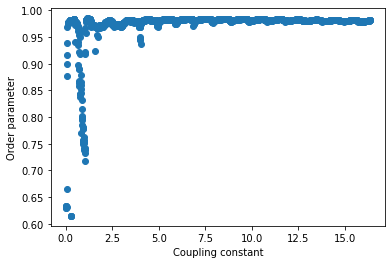

In [19]:
plt.scatter(CC, result)
plt.xlabel('Coupling constant')
plt.ylabel('Order parameter')
plt.show()

### CPU Kuramoto model for veryfing and testing

In [22]:
I = 1j

class KuramotoModel:

    def __init__(self, freq, adjacency_matrix, interaction_const):
        self.freq = np.array(freq)
        self.adjacency_matrix = np.array(adjacency_matrix)
        self.interaction_const = interaction_const

    def update_interaction_const(self, interaction_const):
        self.interaction_const = interaction_const

    def update_adjacency_matrix(self, adjacency_matrix):
        self.adjacency_matrix = np.array(adjacency_matrix)
        
    def update_freq(self, freq):
        self.freq = np.array(freq)

    # not my implementation, depricated
    def evolution_func_(self, phases, time):
        
        vector_func = np.vectorize(lambda x, y, z: np.sin(x - y) * z)
        phases_col = np.reshape(phases, (phases.size, -1))

        interaction_matrix = vector_func(phases * self.adjacency_matrix, phases_col, self.adjacency_matrix)
        interaction_part = self.interaction_const * np.mean(interaction_matrix, axis=1)

        return self.freq + interaction_part

    def evolution_func(self, phases, time):
        res = np.cos(phases) * np.dot(np.sin(phases), self.adjacency_matrix.T) - np.sin(phases) \
            * np.dot(np.cos(phases), self.adjacency_matrix.T)
        res = self.freq + self.interaction_const * res / self.adjacency_matrix.shape[0]
        return res
    
    # not my implementation, depricated
    def evaluate_(self, initial_phases, time):
        return odeint(self.evolution_func_, initial_phases, time)
    
    # DE solver
    def evaluate(self, initial_phases, time):
        return odeint(self.evolution_func, initial_phases, time)

    @staticmethod
    def order_parameter(phases):
        return np.abs(np.mean(np.exp(I * phases), axis=1))

    def phase_diagram(self, interaction_constants, time, thermalization_time, initial_phases=None):
        order_parameters = []
        dur_const = self.interaction_const
        for interaction_constant in interaction_constants:
            if initial_phases is None:
                initial_phases = np.random.uniform(-np.pi, np.pi, size=self.adjacency_matrix.shape[0])
            self.update_interaction_const(interaction_constant)
            phases = self.evaluate(initial_phases, time)
            order_parameter = np.mean(self.order_parameter(phases[thermalization_time:]))
            order_parameters.append(order_parameter)

        self.update_interaction_const(dur_const)
        return order_parameters

### Testing part 

In [31]:
# amount of vertices in graph
vertices = 32

# amount of constants
num_const = 10

# timesteps
timesteps = 100000

# graph
graph = gen_decorated_star(vertices - 1, 1, 0)
# graph = gen_full_connected_graph(vertices)

# setting range of CC
CC = 1e-3 + 8e-1 * np.arange(num_const).astype(np.float32)

# setting natural frequencies
w = np.full(vertices, 1, dtype=np.int8)
w[0] = vertices
# w = w * vertices

# initial data
init = 2 * np.pi * np.random.rand(vertices).astype(np.float64) - np.pi

# model
model = KuramotoModel(0, graph, 1e-3)

# two different realization of solution, my converge faster (at the first sight) :)
result_ = model.evaluate_(init, np.arange(timesteps))
result = model.evaluate(init, np.arange(timesteps))

# order parameter
r = KuramotoModel.order_parameter(result)

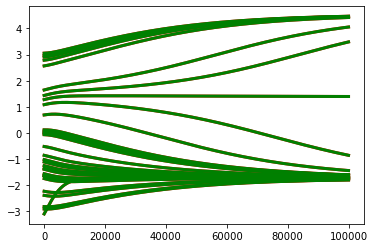

In [32]:
plt.plot(result, color='red', linewidth=3) # graphic
plt.plot(result_, color='green', linewidth=3) # graphic
plt.show() # display

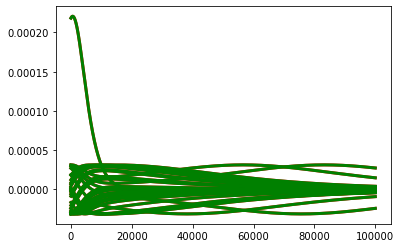

In [35]:
plt.plot(model.evolution_func(result, timesteps), color='red', linewidth=3) # graphic
plt.plot(model.evolution_func(result_, timesteps), color='green', linewidth=3) # graphic
plt.show() # display

In [188]:
model.update_freq(w)

start = time()

order_parameters = model.phase_diagram(CC, np.arange(timesteps), 0, init)

print(f"cpu time computing: {time() - start}")

cpu time computing: 41.98707628250122


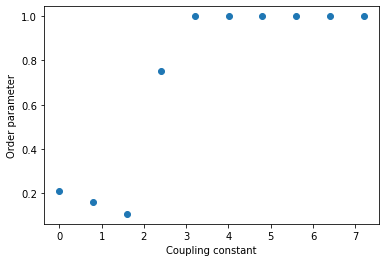

In [189]:
plt.scatter(CC, order_parameters)
plt.xlabel('Coupling constant')
plt.ylabel('Order parameter')
plt.show()

### Conclusion

As we could expected, CUDA computations occurs much more powerfull and fast, but also its' coding and debug took a great amount of time. Moreover, it was a great deal to provide correct numerical calculation for NUMBA in order to decrease influence of precision artefacts. So, as we can see, both methods, cast to star graph, obtained a trivial phase transition close to CC = 2.5. By this code, one could continue conducting experiments.